<a href="https://colab.research.google.com/github/ctorney/learning-to-simulate-tf2/blob/main/test-files/ZonalModel2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install "graph_nets>=1.1" "dm-sonnet>=2.0.0b0" "tensorflow_probability"

In [ ]:
#@title ### Imports

import numpy as np
from math import *
import sys
import random
import time

from tqdm import tqdm
import tensorflow as tf
import os

import functools

from sklearn import neighbors

from typing import Callable

import graph_nets as gn
import sonnet as snt
import collections

from tqdm import tqdm
import pickle

import matplotlib.pyplot as plt
from matplotlib import animation, rc

# Generate Data

In [ ]:
#@title ### Zonal Model

def get_record(group_id,pos,vel):
    feature = { 'group_id': tf.train.Feature(int64_list=tf.train.Int64List(value=[group_id])),
                'pos': tf.train.Feature(bytes_list=tf.train.BytesList(value=[pos.numpy()])),
                'vel': tf.train.Feature(bytes_list=tf.train.BytesList(value=[vel.numpy()]))
                }
    return tf.train.Example(features=tf.train.Features(feature=feature))


class zonal_model:
    def __init__(self, N, timesteps, discard, repeat, L, dt, save_interval,train_directory='train_datasets', valid_directory='valid_datasets', disable_progress=False):
        self.N = N
        self.timesteps = timesteps
        self.discard = discard
        self.B = repeat  # repeat for B batches
        self.L = L
        self.dt = dt
        self.save_interval = save_interval
        
        self.micro_state = np.zeros((self.B, (self.timesteps - self.discard)//self.save_interval, N, 4),dtype=np.float32)

        self.sim_counter=0

        if not os.path.exists(train_directory):
            os.makedirs(train_directory)

        if not os.path.exists(valid_directory):
            os.makedirs(valid_directory)

        self.train_directory = train_directory
        self.valid_directory = valid_directory

        # turn progress bar on or off
        self.disable_progress = disable_progress

        self.valid_fraction = 0.1
        
    def initialise_state(self):

        self.positions = tf.random.uniform((self.B,self.N,2),0.5*self.L, 0.5*self.L+20) #0,self.L)
        #self.positions = tf.random.uniform((self.B,self.N,2),0, self.L) 
        self.angles = tf.random.uniform((self.B,self.N,1), 0, 2*pi) #
        


    def run_sim(self, *params):

        eta, Ra, Ro, Rr, vs, va, sigma = params
        
        record_file = self.train_directory + '/microstates-' + str(self.sim_counter) + '.tfrecords'
        self.writer = tf.io.TFRecordWriter(record_file) 
        
        valid_file = self.valid_directory + '/microstates-' + str(self.sim_counter) + '.tfrecords'
        self.validwriter = tf.io.TFRecordWriter(valid_file) 
        
        # tensorflow function to run an update step
        @tf.function
        def update_tf(X, A):
            cos_A = tf.math.cos(A)
            sin_A = tf.math.sin(A)


            Xx = tf.expand_dims(X[...,0],-1)
            dx = -Xx + tf.linalg.matrix_transpose(Xx)
            dx = tf.where(dx>0.5*self.L, dx-self.L, dx)
            dx = tf.where(dx<-0.5*self.L, dx+self.L, dx)

            Xy = tf.expand_dims(X[...,1],-1)
            dy = -Xy + tf.linalg.matrix_transpose(Xy)
            dy = tf.where(dy>0.5*self.L, dy-self.L, dy)
            dy = tf.where(dy<-0.5*self.L, dy+self.L, dy)


            angle_to_neigh = tf.math.atan2(dy, dx)
            cos_N = tf.math.cos(angle_to_neigh)
            sin_N = tf.math.sin(angle_to_neigh)
            rel_angle_to_neigh = angle_to_neigh - A
            rel_angle_to_neigh = tf.math.atan2(tf.math.sin(rel_angle_to_neigh), tf.math.cos(rel_angle_to_neigh))
            
            dist = tf.math.sqrt(tf.square(dx)+tf.square(dy))
    
            # repulsion 
            rep_x = tf.where(dist<=Rr, -dx, tf.zeros_like(dx))
            rep_x = tf.where(rel_angle_to_neigh<0.5*va, rep_x, tf.zeros_like(rep_x))
            rep_x = tf.where(rel_angle_to_neigh>-0.5*va, rep_x, tf.zeros_like(rep_x))
            rep_x = tf.math.divide_no_nan(rep_x,tf.math.square(dist))
            rep_x = tf.reduce_sum(rep_x,axis=2)

            rep_y = tf.where(dist<=Rr, -dy, tf.zeros_like(dy))
            rep_y = tf.where(rel_angle_to_neigh<0.5*va, rep_y, tf.zeros_like(rep_y))
            rep_y = tf.where(rel_angle_to_neigh>-0.5*va, rep_y, tf.zeros_like(rep_y))
            rep_y = tf.math.divide_no_nan(rep_y,tf.math.square(dist))
            rep_y = tf.reduce_sum(rep_y,axis=2)

            # alignment 
            align_x = tf.where(dist<=Ro, cos_A, tf.zeros_like(cos_A))
            align_x = tf.where(rel_angle_to_neigh<0.5*va, align_x, tf.zeros_like(align_x))
            align_x = tf.where(rel_angle_to_neigh>-0.5*va, align_x, tf.zeros_like(align_x))
            align_x = tf.reduce_sum(align_x,axis=1)
            
            align_y = tf.where(dist<=Ro, sin_A, tf.zeros_like(sin_A))
            align_y = tf.where(rel_angle_to_neigh<0.5*va, align_y, tf.zeros_like(align_y))
            align_y = tf.where(rel_angle_to_neigh>-0.5*va, align_y, tf.zeros_like(align_y))
            align_y = tf.reduce_sum(align_y,axis=1)

            al_norm = tf.math.sqrt(align_x**2+align_y**2)
            align_x = tf.math.divide_no_nan(align_x,al_norm)
            align_y = tf.math.divide_no_nan(align_y,al_norm)

            # attractive interactions
            attr_x = tf.where(dist<=Ra, dx, tf.zeros_like(dx))
            attr_x = tf.where(rel_angle_to_neigh<0.5*va, attr_x, tf.zeros_like(attr_x))
            attr_x = tf.where(rel_angle_to_neigh>-0.5*va, attr_x, tf.zeros_like(attr_x))
            attr_x = tf.reduce_sum(attr_x,axis=2)

            attr_y = tf.where(dist<=Ra, dy, tf.zeros_like(dy))
            attr_y = tf.where(rel_angle_to_neigh<0.5*va, attr_y, tf.zeros_like(attr_y))
            attr_y = tf.where(rel_angle_to_neigh>-0.5*va, attr_y, tf.zeros_like(attr_y))
            attr_y = tf.reduce_sum(attr_y,axis=2)

            at_norm = tf.math.sqrt(attr_x**2+attr_y**2)
            attr_x = tf.math.divide_no_nan(attr_x,at_norm)
            attr_y = tf.math.divide_no_nan(attr_y,at_norm)

            # combine angles and convert to desired angle change
            social_x = rep_x + align_x + attr_x
            social_y = rep_y + align_y + attr_y

            d_angle = tf.math.atan2(social_y,social_x)
            d_angle = tf.expand_dims(d_angle,-1)

            
            d_angle = tf.math.atan2((1-eta)*tf.math.sin(d_angle) + eta*sin_A, (1-eta)*tf.math.cos(d_angle) + eta*cos_A)

            d_angle = d_angle - A
            d_angle = tf.where(d_angle>pi, d_angle-2*pi, d_angle)
            d_angle = tf.where(d_angle<-pi, d_angle+2*pi, d_angle)


            # add perception noise
            noise = tf.random.normal(shape=(self.B,self.N,1),mean=0,stddev=sigma*(self.dt**0.5))
            d_angle = d_angle + noise
            
            # restrict to maximum turning angle
            #d_angle = tf.where(tf.math.abs(d_angle)>eta*self.dt, tf.math.sign(d_angle)*eta*self.dt, d_angle)
            
            # rotate headings
            A = A + d_angle
            
            # update positions
            velocity = self.dt*vs*tf.concat([tf.cos(A),tf.sin(A)],axis=-1)
            X += velocity

            # add periodic boundary conditions
            A = tf.where(A<-pi,  A+2*pi, A)
            A = tf.where(A>pi, A-2*pi, A)

            X = tf.where(X>self.L, X-self.L, X)
            X = tf.where(X<0, X+self.L, X)

            X = tf.where(X>self.L, X-self.L, X)
            X = tf.where(X<0, X+self.L, X)

            return X, A
            
        self.initialise_state()

        counter=0
        for i in tqdm(range(self.timesteps),disable=self.disable_progress):
            self.positions, self.angles = update_tf(self.positions,  self.angles)
            if i>=self.discard:
                if i%self.save_interval==0:
                    # store in an array in case we want to visualise
                    self.micro_state[:,counter,:,0:2] = self.positions.numpy()
                    self.micro_state[:,counter,:,2:3] = np.cos(self.angles.numpy())
                    self.micro_state[:,counter,:,3:4] = np.sin(self.angles.numpy())
                        
                    

                    counter = counter + 1

        for b in range(self.B):
            self.save_tf_record(b)

        self.writer.close()
        self.validwriter.close()
        self.sim_counter+=1
        return 

    def save_tf_record(self, b):
        pos =  tf.io.serialize_tensor(self.micro_state[b,:,:,0:2])
        vel =  tf.io.serialize_tensor(self.micro_state[b,:,:,2:4])

        tf_record = get_record(b,pos,vel)
        if b> self.B*self.valid_fraction:
            self.writer.write(tf_record.SerializeToString())
        else:
            self.validwriter.write(tf_record.SerializeToString())

        
        return 

In [ ]:
#@title ### Params

n_points=50 #10

param_values = np.linspace(0,25,n_points)
L= 200
N= 100 
repeat = 100
discard = 0
timesteps = 200
save_interval=1
dt=0.1


sim = zonal_model(N,timesteps=timesteps+discard,discard=discard,L=L,repeat=repeat, dt=dt,save_interval=save_interval,disable_progress=False)

latt=0  # adapt
lrep= 1 # adapt
lali= 5 # adapt
eta=0.9 # adapt
va=2*pi # adapt
vs=5 # fix 
sigma=0.1 

In [ ]:
#@title ### Create Training Data

def evaluate_zonal_model(X):
    sim.run_sim(eta, latt, X, lrep, vs, va, sigma)
    return

evaluate_zonal_model(0)

"""
for i in tqdm(range(param_values.shape[0])):
    evaluate_zonal_model(param_values[i])
"""

100%|██████████| 200/200 [00:27<00:00,  7.40it/s]


'\nfor i in tqdm(range(param_values.shape[0])):\n    evaluate_zonal_model(param_values[i])\n'

# Utils

In [ ]:
#@title ### connectivity_utils

def _compute_connectivity(positions, radius, add_self_edges):
  """Get the indices of connected edges with radius connectivity.
  Args:
    positions: Positions of nodes in the graph. Shape:
      [num_nodes_in_graph, num_dims].
    radius: Radius of connectivity.
    add_self_edges: Whether to include self edges or not.
  Returns:
    senders indices [num_edges_in_graph]
    receiver indices [num_edges_in_graph]
  """
  tree = neighbors.KDTree(positions)
  receivers_list = tree.query_radius(positions, r=radius)
  num_nodes = len(positions)
  senders = np.repeat(range(num_nodes), [len(a) for a in receivers_list])
  receivers = np.concatenate(receivers_list, axis=0)

  if not add_self_edges:
    # Remove self edges.
    mask = senders != receivers
    senders = senders[mask]
    receivers = receivers[mask]

  return senders, receivers


def _compute_connectivity_for_batch(
    positions, n_node, radius, add_self_edges):
  """`compute_connectivity` for a batch of graphs.
  Args:
    positions: Positions of nodes in the batch of graphs. Shape:
      [num_nodes_in_batch, num_dims].
    n_node: Number of nodes for each graph in the batch. Shape:
      [num_graphs in batch].
    radius: Radius of connectivity.
    add_self_edges: Whether to include self edges or not.
  Returns:
    senders indices [num_edges_in_batch]
    receiver indices [num_edges_in_batch]
    number of edges per graph [num_graphs_in_batch]
  """

  # TODO(alvarosg): Consider if we want to support batches here or not.
  # Separate the positions corresponding to particles in different graphs.
  positions_per_graph_list = np.split(positions, np.cumsum(n_node[:-1]), axis=0)
  receivers_list = []
  senders_list = []
  n_edge_list = []
  num_nodes_in_previous_graphs = 0

  # Compute connectivity for each graph in the batch.
  for positions_graph_i in positions_per_graph_list:
    senders_graph_i, receivers_graph_i = _compute_connectivity(
        positions_graph_i, radius, add_self_edges)

    num_edges_graph_i = len(senders_graph_i)
    n_edge_list.append(num_edges_graph_i)

    # Because the inputs will be concatenated, we need to add offsets to the
    # sender and receiver indices according to the number of nodes in previous
    # graphs in the same batch.
    receivers_list.append(receivers_graph_i + num_nodes_in_previous_graphs)
    senders_list.append(senders_graph_i + num_nodes_in_previous_graphs)

    num_nodes_graph_i = len(positions_graph_i)
    num_nodes_in_previous_graphs += num_nodes_graph_i

  # Concatenate all of the results.
  senders = np.concatenate(senders_list, axis=0).astype(np.int32)
  receivers = np.concatenate(receivers_list, axis=0).astype(np.int32)
  n_edge = np.stack(n_edge_list).astype(np.int32)

  return senders, receivers, n_edge


def compute_connectivity_for_batch_pyfunc(
    positions, n_node, radius, add_self_edges=True):
  """`_compute_connectivity_for_batch` wrapped in a pyfunc."""
  partial_fn = functools.partial(
      _compute_connectivity_for_batch, add_self_edges=add_self_edges)
  #print("Connectivity_func", positions.shape, n_node.shape, radius)
  senders, receivers, n_edge = tf.py_function(
      partial_fn,
      [positions, n_node, radius],
      [tf.int32, tf.int32, tf.int32])
  senders.set_shape([None])
  receivers.set_shape([None])
  n_edge.set_shape(n_node.get_shape())
  return senders, receivers, n_edge

In [ ]:
#@title ### graph_network

Reducer = Callable[[tf.Tensor, tf.Tensor, tf.Tensor], tf.Tensor]

def build_mlp(
    hidden_size: int, num_hidden_layers: int, output_size: int) -> snt.Module:
  """Builds an MLP."""
  return snt.nets.MLP(
      output_sizes=[hidden_size] * num_hidden_layers + [output_size])


class EncodeProcessDecode(snt.Module):
  """Encode-Process-Decode function approximator for learnable simulator."""

  def __init__(
      self,
      latent_size: int,
      mlp_hidden_size: int,
      mlp_num_hidden_layers: int,
      num_message_passing_steps: int,
      output_size: int,
      reducer: Reducer = tf.math.unsorted_segment_sum,
      name: str = "EncodeProcessDecode"):
    """Inits the model.
    Args:
      latent_size: Size of the node and edge latent representations.
      mlp_hidden_size: Hidden layer size for all MLPs.
      mlp_num_hidden_layers: Number of hidden layers in all MLPs.
      num_message_passing_steps: Number of message passing steps.
      output_size: Output size of the decode node representations as required
        by the downstream update function.
      reducer: Reduction to be used when aggregating the edges in the nodes in
        the interaction network. This should be a callable whose signature
        matches tf.math.unsorted_segment_sum.
      name: Name of the model.
    """

    super().__init__(name=name)

    self._latent_size = latent_size
    self._mlp_hidden_size = mlp_hidden_size
    self._mlp_num_hidden_layers = mlp_num_hidden_layers
    self._num_message_passing_steps = num_message_passing_steps
    self._output_size = output_size
    self._reducer = reducer

    #with self._enter_variable_scope():
    self._networks_builder()

  def __call__(self, input_graph: gn.graphs.GraphsTuple) -> tf.Tensor:
    """Forward pass of the learnable dynamics model."""

    # Encode the input_graph.
    latent_graph_0 = self._encode(input_graph)

    # Do `m` message passing steps in the latent graphs.
    latent_graph_m = self._process(latent_graph_0)

    # Decode from the last latent graph.
    return self._decode(latent_graph_m)

  def _networks_builder(self):
    """Builds the networks."""
    def build_mlp_with_layer_norm():
      mlp = build_mlp(
          hidden_size=self._mlp_hidden_size,
          num_hidden_layers=self._mlp_num_hidden_layers,
          output_size=self._latent_size)
      return snt.Sequential([mlp, snt.LayerNorm(axis=slice(1, None),create_scale=False,create_offset=False)])

    # The encoder graph network independently encodes edge and node features.
    encoder_kwargs = dict(
        edge_model_fn=build_mlp_with_layer_norm,
        node_model_fn=build_mlp_with_layer_norm)
    self._encoder_network = gn.modules.GraphIndependent(**encoder_kwargs)
    # Create `num_message_passing_steps` graph networks with unshared parameters
    # that update the node and edge latent features.
    # Note that we can use `modules.InteractionNetwork` because
    # it also outputs the messages as updated edge latent features.
    self._processor_networks = []
    for _ in range(self._num_message_passing_steps):
      self._processor_networks.append(
          gn.modules.InteractionNetwork(
              edge_model_fn=build_mlp_with_layer_norm,
              node_model_fn=build_mlp_with_layer_norm,
              reducer=self._reducer))
    # The decoder MLP decodes node latent features into the output size.
    self._decoder_network = build_mlp(
        hidden_size=self._mlp_hidden_size,
        num_hidden_layers=self._mlp_num_hidden_layers,
        output_size=self._output_size)
  def _encode(
      self, input_graph: gn.graphs.GraphsTuple) -> gn.graphs.GraphsTuple:
    """Encodes the input graph features into a latent graph."""

    # Copy the globals to all of the nodes, if applicable.
    if input_graph.globals is not None:
      broadcasted_globals = gn.blocks.broadcast_globals_to_nodes(input_graph)
      input_graph = input_graph.replace(
          nodes=tf.concat([input_graph.nodes, broadcasted_globals], axis=-1),
          globals=None)

    # Encode the node and edge features.
    latent_graph_0 = self._encoder_network(input_graph)

    return latent_graph_0

  def _process(
      self, latent_graph_0: gn.graphs.GraphsTuple) -> gn.graphs.GraphsTuple:
    """Processes the latent graph with several steps of message passing."""

    # Do `m` message passing steps in the latent graphs.
    # (In the shared parameters case, just reuse the same `processor_network`)
    latent_graph_prev_k = latent_graph_0
    latent_graph_k = latent_graph_0
    for processor_network_k in self._processor_networks:
      latent_graph_k = self._process_step(
          processor_network_k, latent_graph_prev_k)
      latent_graph_prev_k = latent_graph_k

    latent_graph_m = latent_graph_k
    return latent_graph_m

  def _process_step(
      self, processor_network_k: snt.Module,
      latent_graph_prev_k: gn.graphs.GraphsTuple) -> gn.graphs.GraphsTuple:
    """Single step of message passing with node/edge residual connections."""

    # One step of message passing.
    latent_graph_k = processor_network_k(latent_graph_prev_k)

    # Add residuals.
    latent_graph_k = latent_graph_k.replace(
        nodes=latent_graph_k.nodes+latent_graph_prev_k.nodes,
        edges=latent_graph_k.edges+latent_graph_prev_k.edges)
    return latent_graph_k

  def _decode(self, latent_graph: gn.graphs.GraphsTuple) -> tf.Tensor:
    """Decodes from the latent graph."""
    return self._decoder_network(latent_graph.nodes)

In [ ]:
#@title ### learned_simulator

STD_EPSILON = 1e-8


class LearnedSimulator(snt.Module):
  """Learned simulator from https://arxiv.org/pdf/2002.09405.pdf."""

  def __init__(
      self,
      num_dimensions,
      connectivity_radius,
      graph_network_kwargs,
      boundaries,
      normalization_stats,
      num_particle_types,
      particle_type_embedding_size,
      name="LearnedSimulator"):
    """Inits the model.
    Args:
      num_dimensions: Dimensionality of the problem.
      connectivity_radius: Scalar with the radius of connectivity.
      graph_network_kwargs: Keyword arguments to pass to the learned part
        of the graph network `model.EncodeProcessDecode`.
      boundaries: List of 2-tuples, containing the lower and upper boundaries of
        the cuboid containing the particles along each dimensions, matching
        the dimensionality of the problem.
      normalization_stats: Dictionary with statistics with keys "acceleration"
        and "velocity", containing a named tuple for each with mean and std
        fields, matching the dimensionality of the problem.
      num_particle_types: Number of different particle types.
      particle_type_embedding_size: Embedding size for the particle type.
      name: Name of the Sonnet module.
    """
    super().__init__(name=name)

    self._connectivity_radius = connectivity_radius
    self._num_particle_types = num_particle_types
    self._boundaries = boundaries
    self._normalization_stats = normalization_stats
    #with self._enter_variable_scope():
    self._graph_network = EncodeProcessDecode(output_size=num_dimensions, **graph_network_kwargs)

    if self._num_particle_types > 1:
        self._particle_type_embedding = tf.compat.v1.get_variable(
            "particle_embedding",
            [self._num_particle_types, particle_type_embedding_size],
            trainable=True, use_resource=True)

  def __call__(self, position_sequence, velocity_sequence, n_particles_per_example=N,
             global_context=None, particle_types=None):
    """Produces a model step, outputting the next position for each particle.
    Args:
      position_sequence: Sequence of positions for each node in the batch,
        with shape [num_particles_in_batch, sequence_length, num_dimensions]
      n_particles_per_example: Number of particles for each graph in the batch
        with shape [batch_size]
      global_context: Tensor of shape [batch_size, context_size], with global
        context.
      particle_types: Integer tensor of shape [num_particles_in_batch] with
        the integer types of the particles, from 0 to `num_particle_types - 1`.
        If None, we assume all particles are the same type.
    Returns:
      Next position with shape [num_particles_in_batch, num_dimensions] for one
      step into the future from the input sequence.
    """
    input_graphs_tuple = self._encoder_preprocessor(
        position_sequence,
        velocity_sequence,
        n_particles_per_example,
        global_context=None,
        particle_types=None)

    normalized_acceleration = self._graph_network(input_graphs_tuple)

    next_position, next_velocity = self._decoder_postprocessor(
        normalized_acceleration, position_sequence)

    return next_position, next_velocity

  def _encoder_preprocessor(
      self, position_sequence, velocity_sequence, n_node, global_context, particle_types):
    # Extract important features from the position_sequence.
    most_recent_position = position_sequence[-1]

    #print("encoder", position_sequence.shape, velocity_sequence.shape, n_node)

    # Get connectivity of the graph.
    (senders, receivers, n_edge
     ) = compute_connectivity_for_batch_pyfunc(
         most_recent_position, n_node, self._connectivity_radius)

    # Collect node features.
    node_features = []

    #Calculate velocity mean and std
    vm = tf.reduce_mean(velocity_sequence)
    vstd = tf.math.reduce_std(velocity_sequence)

    # Normalized velocity sequence, merging spatial an time axis.
    normalized_velocity_sequence = (
        velocity_sequence - vm) / vstd
    
    normalized_velocity_sequence = tf.reshape(normalized_velocity_sequence, shape=[N,-1])
    node_features.append(normalized_velocity_sequence)

    # Normalized clipped distances to lower and upper boundaries.
    # boundaries are an array of shape [num_dimensions, 2], where the second
    # axis, provides the lower/upper boundaries.
    boundaries = tf.constant(self._boundaries, dtype=tf.float32)
    distance_to_lower_boundary = (
        most_recent_position - tf.expand_dims(boundaries[:, 0], 0))
    distance_to_upper_boundary = (
        tf.expand_dims(boundaries[:, 1], 0) - most_recent_position)
    distance_to_boundaries = tf.concat(
        [distance_to_lower_boundary, distance_to_upper_boundary], axis=1)
    normalized_clipped_distance_to_boundaries = tf.clip_by_value(
        distance_to_boundaries / self._connectivity_radius, -1., 1.)
    node_features.append(normalized_clipped_distance_to_boundaries)

    # Particle type.
    if self._num_particle_types > 1:
      particle_type_embeddings = tf.nn.embedding_lookup(
          self._particle_type_embedding, particle_types)
      node_features.append(particle_type_embeddings)

    # Collect edge features.
    edge_features = []

    # Relative displacement and distances normalized to radius
    normalized_relative_displacements = (
        tf.gather(most_recent_position, senders) -
        tf.gather(most_recent_position, receivers)) / self._connectivity_radius
    edge_features.append(normalized_relative_displacements)

    normalized_relative_distances = tf.norm(
        normalized_relative_displacements, axis=-1, keepdims=True)
    edge_features.append(normalized_relative_distances)

    # Normalize the global context.
    if global_context is not None:
      context_stats = self._normalization_stats["context"]
      # Context in some datasets are all zero, so add an epsilon for numerical
      # stability.
      global_context = (global_context - context_stats.mean) / tf.math.maximum(
          context_stats.std, STD_EPSILON)
      
    return gn.graphs.GraphsTuple(
        nodes=tf.concat(node_features, axis=-1),
        edges=tf.concat(edge_features, axis=-1),
        globals=global_context,  # self._graph_net will appending this to nodes.
        n_node=n_node,
        n_edge=n_edge,
        senders=senders,
        receivers=receivers,
        )

  def _decoder_postprocessor(self, normalized_acceleration, position_sequence):

    # The model produces the output in normalized space so we apply inverse
    # normalization.
    accmean = tf.reduce_mean(normalized_acceleration)
    accstd = tf.math.reduce_std(normalized_acceleration)
    acceleration = (
        normalized_acceleration * accstd
        ) + accmean

    # Use an Euler integrator to go from acceleration to position, assuming
    # a dt=1 corresponding to the size of the finite difference.
    most_recent_position = position_sequence[-1]
    most_recent_velocity = most_recent_position - position_sequence[-2]

    new_velocity = most_recent_velocity + acceleration  # * dt = 1
    new_position = most_recent_position + new_velocity  # * dt = 1
    return new_position, new_velocity

  def get_predicted_and_target_normalized_accelerations(
      self, next_position, position_sequence_noise, position_sequence, velocity_sequence,
      n_particles_per_example, global_context=None, particle_types=None):  # pylint: disable=g-doc-args
    """Produces normalized and predicted acceleration targets.
    Args:
      next_position: Tensor of shape [num_particles_in_batch, num_dimensions]
        with the positions the model should output given the inputs.
      position_sequence_noise: Tensor of the same shape as `position_sequence`
        with the noise to apply to each particle.
      position_sequence, n_node, global_context, particle_types: Inputs to the
        model as defined by `_build`.
    Returns:
      Tensors of shape [num_particles_in_batch, num_dimensions] with the
        predicted and target normalized accelerations.
    """

    # Add noise to the input position sequence.
    noisy_position_sequence = position_sequence + position_sequence_noise

    # Perform the forward pass with the noisy position sequence.
    input_graphs_tuple = self._encoder_preprocessor(
        noisy_position_sequence, velocity_sequence, n_particles_per_example, global_context,
        particle_types)
    predicted_normalized_acceleration = self._graph_network(input_graphs_tuple)

    # Calculate the target acceleration, using an `adjusted_next_position `that
    # is shifted by the noise in the last input position.

    next_position_adjusted = next_position + position_sequence_noise[-1]
    target_normalized_acceleration = self._inverse_decoder_postprocessor(
        next_position_adjusted, noisy_position_sequence)
    # As a result the inverted Euler update in the `_inverse_decoder` produces:
    # * A target acceleration that does not explicitly correct for the noise in
    #   the input positions, as the `next_position_adjusted` is different
    #   from the true `next_position`.
    # * A target acceleration that exactly corrects noise in the input velocity
    #   since the target next velocity calculated by the inverse Euler update
    #   as `next_position_adjusted - noisy_position_sequence[:,-1]`
    #   matches the ground truth next velocity (noise cancels out).

    return predicted_normalized_acceleration, target_normalized_acceleration

  def _inverse_decoder_postprocessor(self, next_position, position_sequence):
    """Inverse of `_decoder_postprocessor`."""

    previous_position = position_sequence[-1]
    previous_velocity = previous_position - position_sequence[-2]
    next_velocity = next_position - previous_position
    acceleration = next_velocity - previous_velocity

    accmean = tf.reduce_mean(acceleration)
    accstd = tf.math.reduce_std(acceleration)
    normalized_acceleration = (
        acceleration - accmean) / accstd
    return normalized_acceleration


def time_diff(input_sequence):
  return input_sequence[:, 1:] - input_sequence[:, :-1]

In [ ]:
#@title ### noise_utils


def get_random_walk_noise_for_position_sequence(
    position_sequence, noise_std_last_step):
  """Returns random-walk noise in the velocity applied to the position."""

  velocity_sequence = time_diff(position_sequence)

  # We want the noise scale in the velocity at the last step to be fixed.
  # Because we are going to compose noise at each step using a random_walk:
  # std_last_step**2 = num_velocities * std_each_step**2
  # so to keep `std_last_step` fixed, we apply at each step:
  # std_each_step `std_last_step / np.sqrt(num_input_velocities)`
  # TODO(alvarosg): Make sure this is consistent with the value and
  # description provided in the paper.
  num_velocities = velocity_sequence.shape.as_list()[1]
  velocity_sequence_noise = tf.random.normal(
      tf.shape(velocity_sequence),
      stddev=noise_std_last_step / num_velocities ** 0.5,
      dtype=position_sequence.dtype)

  # Apply the random walk.
  velocity_sequence_noise = tf.cumsum(velocity_sequence_noise, axis=1)

  # Integrate the noise in the velocity to the positions, assuming
  # an Euler intergrator and a dt = 1, and adding no noise to the very first
  # position (since that will only be used to calculate the first position
  # change).
  position_sequence_noise = tf.concat([
      tf.zeros_like(velocity_sequence_noise[:, 0:1]),
      tf.cumsum(velocity_sequence_noise, axis=1)], axis=1)
  return position_sequence_noise

In [ ]:
#@title ### reading_utils

# Create a description of the features.
_FEATURE_DESCRIPTION = {
    'pos': tf.io.FixedLenSequenceFeature([timesteps//save_interval, N, 2], tf.string),
    'vel': tf.io.FixedLenSequenceFeature([timesteps//save_interval, N, 2], tf.string)
}

_FEATURE_DESCRIPTION_WITH_GLOBAL_CONTEXT = _FEATURE_DESCRIPTION.copy()
_FEATURE_DESCRIPTION_WITH_GLOBAL_CONTEXT['step_context'] = tf.io.VarLenFeature(
    tf.string)

_FEATURE_DTYPES = {
    'pos': {
        'in': np.float32,
        'out': tf.float32
    },
    'vel': {
        'in': np.float32,
        'out': tf.float32
    }
}

_CONTEXT_FEATURES = {
    'group_id': tf.io.FixedLenFeature([1],tf.int64)
}


def convert_to_tensor(x, encoded_dtype):
  if len(x) == 1:
    out = np.frombuffer(x[0].numpy(), dtype=encoded_dtype)
  else:
    out = []
    for el in x:
      out.append(np.frombuffer(el.numpy(), dtype=encoded_dtype))
  out = tf.convert_to_tensor(np.array(out))
  return out



def split_trajectory(context, features, window_length=7):
  """Splits trajectory into sliding windows."""
  # Our strategy is to make sure all the leading dimensions are the same size,
  # then we can use from_tensor_slices.
  
  trajectory_length = features['pos'].get_shape().as_list()[0]

  # We then stack window_length position changes so the final
  # trajectory length will be - window_length +1 (the 1 to make sure we get
  # the last split).
  input_trajectory_length = trajectory_length - window_length + 1

  model_input_features = {}
  # Prepare the context features per step.
  model_input_features['group_id'] = tf.tile(
      tf.expand_dims(context['group_id'], axis=0),
      [input_trajectory_length, 1])

  if 'step_context' in features:
    global_stack = []
    for idx in range(input_trajectory_length):
      global_stack.append(features['step_context'][idx:idx + window_length])
    model_input_features['step_context'] = tf.stack(global_stack)

  pos_stack = []
  for idx in range(input_trajectory_length):
    pos_stack.append(features['pos'][idx:idx + window_length])
  # Get the corresponding positions
  model_input_features['pos'] = tf.stack(pos_stack)

  vel_stack = []
  for idx in range(input_trajectory_length):
    vel_stack.append(features['vel'][idx:idx + window_length])
  # Get the corresponding velocities
  model_input_features['vel'] = tf.stack(vel_stack)

  return tf.data.Dataset.from_tensor_slices(model_input_features)

def print_graphs_tuple(graphs_tuple):
  print("Shapes of `GraphsTuple`'s fields:")
  print(graphs_tuple.map(lambda x: x if x is None else x.shape, fields=gn.graphs.ALL_FIELDS))
  # print("\nData contained in `GraphsTuple`'s fields:")
  # print("globals:\n{}".format(graphs_tuple.globals))
  # print("nodes:\n{}".format(graphs_tuple.nodes))
  # print("edges:\n{}".format(graphs_tuple.edges))
  # print("senders:\n{}".format(graphs_tuple.senders))
  # print("receivers:\n{}".format(graphs_tuple.receivers))
  # print("n_node:\n{}".format(graphs_tuple.n_node))
  # print("n_edge:\n{}".format(graphs_tuple.n_edge))

#print_graphs_tuple(graphs_tuple)

# Preprocessing

In [ ]:
#@title ### Colin Code

#Create a tf.data.Dataset from the TFRecord.
ds = tf.data.TFRecordDataset(['train_datasets/microstates-' + str(i) + '.tfrecords' for i in range(1)])

WINDOW_SIZE=7

def _parse_record(x):
  feature_description = {'group_id': tf.io.FixedLenFeature([], tf.int64),
                        'pos': tf.io.FixedLenFeature([], tf.string),
                        'vel': tf.io.FixedLenFeature([], tf.string)}
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(x, feature_description)

def _parse_tensor(x):
    output = {'group_id': x['group_id'],
                'pos': tf.io.parse_tensor(x['pos'],out_type=tf.float32),
                'vel': tf.io.parse_tensor(x['vel'],out_type=tf.float32)}
    return output

def create_data(ds, WINDOW_SIZE=7):
    # map the record to features
    ds = ds.map(_parse_record)

    # map the features to tensors
    ds = ds.map(_parse_tensor)


    def make_window_dataset(x):
        # make a dataset from the time series tensor
        windows = tf.data.Dataset.from_tensor_slices((x['pos'],x['vel']))
        #print(windows)
        # convert to windows
        windows = windows.window(WINDOW_SIZE+1, shift=1, stride=1)
        #print(windows)
        # take a batch of window size and combine pos, vel to a single dataset
        windows = windows.flat_map(lambda pos_ds,vel_ds: tf.data.Dataset.zip((pos_ds.batch(WINDOW_SIZE, drop_remainder=True),vel_ds.batch(WINDOW_SIZE, drop_remainder=True))))
        #print(windows)
        return windows

    # flatten the windowed dataset
    ds = ds.flat_map(make_window_dataset)
    #print(ds)
    ds.shuffle(2000)

    def split_targets(x, y, w=7):
        inputs = (x[0:w-1], y[0:w-1])
        targets = (x[-1], y[-1])
        return (inputs, targets)

    split_with_window = functools.partial(
      split_targets,
      w=WINDOW_SIZE)
    ds = ds.map(split_with_window)

    return ds

ds = create_data(ds, WINDOW_SIZE)

In [ ]:
#@title ### Preprocessing function

interaction_radius = 15.0
L = 200
def preprocess_data(databatch):
    
    # node features xpos, ypos, xvel, yvel
    # edge features distance, rel angle to receiver
    X = databatch['pos']
    V = databatch['vel']
    
    Xx = tf.expand_dims(X[...,0],-1)
    dx = -Xx + tf.linalg.matrix_transpose(Xx)
    dx = tf.where(dx>0.5*L, dx-L, dx)
    dx = tf.where(dx<-0.5*L, dx+L, dx)

    Xy = tf.expand_dims(X[...,1],-1)
    dy = -Xy + tf.linalg.matrix_transpose(Xy)
    dy = tf.where(dy>0.5*L, dy-L, dy)
    dy = tf.where(dy<-0.5*L, dy+L, dy)



    A = tf.expand_dims(tf.math.atan2(V[...,1],V[...,0]),-1)
    angle_to_neigh = tf.math.atan2(dy, dx)

    rel_angle_to_neigh = angle_to_neigh - A

    dist = tf.math.sqrt(tf.square(dx)+tf.square(dy))

    adj_matrix = tf.where(dist<interaction_radius, tf.ones_like(dist,dtype=tf.int32), tf.zeros_like(dist,dtype=tf.int32))
    adj_matrix = tf.linalg.set_diag(adj_matrix, tf.zeros(tf.shape(adj_matrix)[:2],dtype=tf.int32))
    sender_recv_list = tf.where(adj_matrix)
    n_edge = tf.reduce_sum(adj_matrix, axis=[1,2])
    n_node = tf.ones_like(n_edge)*tf.shape(adj_matrix)[-1]

    senders = sender_recv_list[:,1] + sender_recv_list[:,0]*tf.shape(adj_matrix,out_type=tf.int64)[-1]
    receivers = sender_recv_list[:,2] + sender_recv_list[:,0]*tf.shape(adj_matrix,out_type=tf.int64)[-1]


    edge_distance = tf.expand_dims(tf.gather_nd(dist,sender_recv_list),-1)
    edge_x_distance =  tf.expand_dims(tf.gather_nd(tf.math.cos(rel_angle_to_neigh),sender_recv_list),-1)  # relative to sender heading
    edge_y_distance =  tf.expand_dims( tf.gather_nd(tf.math.sin(rel_angle_to_neigh),sender_recv_list),-1)  # relative to sender heading


    edges = tf.concat([edge_distance,edge_x_distance,edge_y_distance],axis=-1)

    node_positions = tf.reshape(X,(-1,2))
    node_velocities = tf.reshape(V,(-1,2))

    nodes = tf.concat([node_positions,node_velocities],axis=-1)

    gn = graphs.GraphsTuple(nodes=nodes,edges=edges,globals=None,receivers=receivers,senders=senders,n_node=n_node,n_edge=n_edge)
    gn = utils_tf.set_zero_global_features(gn,1)
    
    return gn

In [ ]:
#@title ### More Functions

INPUT_SEQUENCE_LENGTH = WINDOW_SIZE-1  # So we can calculate the last 5 velocities.
NUM_PARTICLE_TYPES = 1
KINEMATIC_PARTICLE_ID = 3

batch_size=5

metadata = {"sequence_length": timesteps//save_interval,
            "dim": 2,
            "acc_mean": 1,
            "acc_std": 1,
            "vel_mean": 1,
            "vel_std": 1,
            "default_connectivity_radius": lali,
            "bounds": [(0,L), (0,L)]
            }

def _read_metadata(data_path):
    with open(os.path.join(data_path, 'metadata.json'), 'rt') as fp:
        return json.loads(fp.read())

def prepare_inputs(tensor_dict):
  """Prepares a single stack of inputs by calculating inputs and targets.

  Computes n_particles_per_example, which is a tensor that contains information
  about how to partition the axis - i.e. which nodes belong to which graph.

  Adds a batch axis to `n_particles_per_example` and `step_context` so they can
  later be batched using `batch_concat`. This batch will be the same as if the
  elements had been batched via stacking.

  Note that all other tensors have a variable size particle axis,
  and in this case they will simply be concatenated along that
  axis.



  Args:
    tensor_dict: A dict of tensors containing positions, and step context (
    if available).

  Returns:
    A tuple of input features and target positions.

  """
  # Position is encoded as [sequence_length, num_particles, dim] but the model
  # expects [num_particles, sequence_length, dim].
  pos = tensor_dict['pos']
  pos = pos[tf.newaxis,...]
  pos = tf.transpose(pos, perm=[0, 2, 1, 3])

  # The target position is the final step of the stack of positions.
  target_position = pos[:, :, -1]

  # Remove the target from the input.
  tensor_dict['pos'] = pos[:, :, :-1]

  # Velocity is encoded as [sequence_length, num_particles, dim] but the model
  # expects [num_particles, sequence_length, dim].
  vel = tensor_dict['vel']
  vel = vel[tf.newaxis, ...]
  vel = tf.transpose(vel, perm=[0, 2, 1, 3])

  # The target position is the final step of the stack of positions.
  target_position = vel[:, :, -1]

  # Remove the target from the input.
  tensor_dict['vel'] = vel[:, :, :-1]

  # Compute the number of particles per example.
  num_particles = tf.shape(pos)[0]
  # Add an extra dimension for stacking via concat.
  tensor_dict['n_particles_per_example'] = num_particles[tf.newaxis]

  if 'step_context' in tensor_dict:
    # Take the input global context. We have a stack of global contexts,
    # and we take the penultimate since the final is the target.
    tensor_dict['step_context'] = tensor_dict['step_context'][-2]
    # Add an extra dimension for stacking via concat.
    tensor_dict['step_context'] = tensor_dict['step_context'][tf.newaxis]
  return tensor_dict, target_position

def prepare_rollout_inputs(context, features):
  """Prepares an inputs trajectory for rollout."""
  out_dict = {**context}
  # Position is encoded as [sequence_length, num_particles, dim] but the model
  # expects [num_particles, sequence_length, dim].
  pos = tf.transpose(features['pos'], [1, 0, 2])
  # The target position is the final step of the stack of positions.
  target_position = pos[:, -1]
  # Remove the target from the input.
  out_dict['pos'] = pos[:, :-1]

  # Compute the number of nodes
  out_dict['n_particles_per_example'] = [tf.shape(pos)[0]]
  if 'step_context' in features:
    out_dict['step_context'] = features['step_context']
  out_dict['is_trajectory'] = tf.constant([True], tf.bool)
  return out_dict, target_position

# Create and Train Model

In [ ]:
#@title ### Create Model
#@markdown loss_fn may be broken - features[0] adds noise to all timesteps

noise_std=6.7e-4
latent_size=128
hidden_size=128
hidden_layers=2
message_passing_steps=10

"""Gets one step model for training simulation."""
#metadata = _read_metadata(data_path)
model_kwargs = dict(
      latent_size=latent_size,
      mlp_hidden_size=hidden_size,
      mlp_num_hidden_layers=hidden_layers,
      num_message_passing_steps=message_passing_steps)
def _combine_std(std_x, std_y):
  return np.sqrt(std_x**2 + std_y**2)

Stats = collections.namedtuple('Stats', ['mean', 'std'])
vel_noise_std=noise_std
acc_noise_std=noise_std
"""Instantiates the simulator."""
# Cast statistics to numpy so they are arrays when entering the model.
cast = lambda v: np.array(v, dtype=np.float32)
acceleration_stats = Stats(cast(metadata['acc_mean']), _combine_std(cast(metadata['acc_std']), acc_noise_std))
velocity_stats = Stats(cast(metadata['vel_mean']),_combine_std(cast(metadata['vel_std']), vel_noise_std))
normalization_stats = {'acceleration': acceleration_stats, 'velocity': velocity_stats}



if 'context_mean' in metadata:
    context_stats = Stats(cast(metadata['context_mean']), cast(metadata['context_std']))
    normalization_stats['context'] = context_stats


simulator = LearnedSimulator(
      num_dimensions=metadata['dim'],
      connectivity_radius=metadata['default_connectivity_radius'],
      graph_network_kwargs=model_kwargs,
      boundaries=metadata['bounds'],
      num_particle_types=NUM_PARTICLE_TYPES,
      normalization_stats=normalization_stats,
      particle_type_embedding_size=16)


KINEMATIC_PARTICLE_ID = 3
def get_kinematic_mask(particle_types):
  """Returns a boolean mask, set to true for kinematic (obstacle) particles."""
  return tf.equal(particle_types, KINEMATIC_PARTICLE_ID)

#@tf.function
def loss_fn(features, labels):
    target_next_position = labels[0]
    # Sample the noise to add to the inputs to the model during training.
    sampled_noise = get_random_walk_noise_for_position_sequence(
        features[0], noise_std_last_step=noise_std)
    non_kinematic_mask = tf.logical_not(get_kinematic_mask(tf.zeros(N)))
    noise_mask = tf.cast(non_kinematic_mask, sampled_noise.dtype)
    sampled_noise *= noise_mask[tf.newaxis,:,tf.newaxis]

    # Get the predictions and target accelerations.
    pred_target = simulator.get_predicted_and_target_normalized_accelerations(
        next_position=target_next_position,
        position_sequence=features[0],
        position_sequence_noise=sampled_noise,
        velocity_sequence=features[1],
        n_particles_per_example=tf.constant([N]),
        particle_types=None,
        global_context=None)

    pred_acceleration, target_acceleration = pred_target

    # Calculate the loss and mask out loss on kinematic particles/
    loss = (pred_acceleration - target_acceleration)**2
    num_non_kinematic = tf.reduce_sum(tf.cast(non_kinematic_mask, tf.float32))
    loss = tf.where(tf.expand_dims(non_kinematic_mask,-1), loss, tf.zeros_like(loss))
    loss = tf.reduce_sum(loss) / tf.reduce_sum(num_non_kinematic)
    
    return loss



In [ ]:
#@title ### Train

min_lr = 1e-6
lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4 - min_lr,
                                decay_steps=int(5e6),
                                decay_rate=0.1) #+ min_lr
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# @tf.function - ideally we'd like to decorate this with tf.function for faster code - but the connectivity utils is written using numpy so will need to be converted to tensorflow code
def train_step(x, y):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(x,y)
    grads = tape.gradient(loss_value, simulator.trainable_variables)
    optimizer.apply_gradients(zip(grads, simulator.trainable_variables))
    return loss_value

max_data_points = -1 #Set to -1 to include all data points
ds = ds.take(max_data_points)

epochs = 2
loss_values = np.zeros((epochs, len(list(ds))))
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in tqdm(enumerate(iter(ds)), total=len(list(ds))):
        loss_value = train_step(x_batch_train, y_batch_train)
        loss_values[epoch, step] = loss_value
        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %d samples" % ((step + 1) * batch_size))


Start of epoch 0


  0%|          | 1/17266 [00:01<6:00:08,  1.25s/it]

Training loss (for one batch) at step 0: 3.1273
Seen so far: 5 samples


  1%|          | 201/17266 [01:06<2:29:23,  1.90it/s]

Training loss (for one batch) at step 200: 2.0836
Seen so far: 1005 samples


  2%|▏         | 401/17266 [02:11<2:12:38,  2.12it/s]

Training loss (for one batch) at step 400: 2.2037
Seen so far: 2005 samples


  3%|▎         | 601/17266 [03:15<1:55:34,  2.40it/s]

Training loss (for one batch) at step 600: 2.2531
Seen so far: 3005 samples


  5%|▍         | 801/17266 [04:21<1:45:02,  2.61it/s]

Training loss (for one batch) at step 800: 1.9519
Seen so far: 4005 samples


  6%|▌         | 1001/17266 [05:25<1:37:07,  2.79it/s]

Training loss (for one batch) at step 1000: 2.1377
Seen so far: 5005 samples


  7%|▋         | 1201/17266 [06:29<1:25:42,  3.12it/s]

Training loss (for one batch) at step 1200: 2.8198
Seen so far: 6005 samples


  8%|▊         | 1401/17266 [07:32<1:28:50,  2.98it/s]

Training loss (for one batch) at step 1400: 2.0476
Seen so far: 7005 samples


  9%|▉         | 1601/17266 [08:35<1:19:48,  3.27it/s]

Training loss (for one batch) at step 1600: 1.9061
Seen so far: 8005 samples


 10%|█         | 1801/17266 [09:39<1:23:04,  3.10it/s]

Training loss (for one batch) at step 1800: 2.4440
Seen so far: 9005 samples


 12%|█▏        | 2001/17266 [10:43<1:18:21,  3.25it/s]

Training loss (for one batch) at step 2000: 1.8444
Seen so far: 10005 samples


 13%|█▎        | 2201/17266 [11:47<1:18:32,  3.20it/s]

Training loss (for one batch) at step 2200: 1.9859
Seen so far: 11005 samples


 14%|█▍        | 2401/17266 [12:51<1:15:44,  3.27it/s]

Training loss (for one batch) at step 2400: 2.0277
Seen so far: 12005 samples


 15%|█▌        | 2601/17266 [13:55<1:12:54,  3.35it/s]

Training loss (for one batch) at step 2600: 2.0333
Seen so far: 13005 samples


 16%|█▌        | 2801/17266 [14:59<1:10:36,  3.41it/s]

Training loss (for one batch) at step 2800: 1.9848
Seen so far: 14005 samples


 17%|█▋        | 3001/17266 [16:02<1:07:46,  3.51it/s]

Training loss (for one batch) at step 3000: 1.9763
Seen so far: 15005 samples


 19%|█▊        | 3201/17266 [17:06<1:08:10,  3.44it/s]

Training loss (for one batch) at step 3200: 2.0264
Seen so far: 16005 samples


 20%|█▉        | 3401/17266 [18:09<1:06:38,  3.47it/s]

Training loss (for one batch) at step 3400: 1.9888
Seen so far: 17005 samples


 21%|██        | 3601/17266 [19:12<1:06:28,  3.43it/s]

Training loss (for one batch) at step 3600: 2.0006
Seen so far: 18005 samples


 22%|██▏       | 3801/17266 [20:15<1:03:53,  3.51it/s]

Training loss (for one batch) at step 3800: 1.9842
Seen so far: 19005 samples


 23%|██▎       | 4001/17266 [21:20<1:04:55,  3.40it/s]

Training loss (for one batch) at step 4000: 1.9928
Seen so far: 20005 samples


 24%|██▍       | 4201/17266 [22:23<1:02:47,  3.47it/s]

Training loss (for one batch) at step 4200: 1.9833
Seen so far: 21005 samples


 25%|██▌       | 4401/17266 [23:26<1:02:13,  3.45it/s]

Training loss (for one batch) at step 4400: 1.9796
Seen so far: 22005 samples


 27%|██▋       | 4601/17266 [24:31<1:01:49,  3.41it/s]

Training loss (for one batch) at step 4600: 2.0319
Seen so far: 23005 samples


 28%|██▊       | 4801/17266 [25:36<1:00:38,  3.43it/s]

Training loss (for one batch) at step 4800: 2.0504
Seen so far: 24005 samples


 29%|██▉       | 5001/17266 [26:40<57:10,  3.58it/s]

Training loss (for one batch) at step 5000: 1.9930
Seen so far: 25005 samples


 30%|███       | 5201/17266 [27:44<56:41,  3.55it/s]

Training loss (for one batch) at step 5200: 2.0280
Seen so far: 26005 samples


 31%|███▏      | 5401/17266 [28:48<56:23,  3.51it/s]

Training loss (for one batch) at step 5400: 1.9923
Seen so far: 27005 samples


 32%|███▏      | 5601/17266 [29:51<54:20,  3.58it/s]

Training loss (for one batch) at step 5600: 2.0005
Seen so far: 28005 samples


 34%|███▎      | 5801/17266 [30:55<52:22,  3.65it/s]

Training loss (for one batch) at step 5800: 2.0010
Seen so far: 29005 samples


 35%|███▍      | 6001/17266 [32:02<53:06,  3.54it/s]

Training loss (for one batch) at step 6000: 2.0016
Seen so far: 30005 samples


 36%|███▌      | 6201/17266 [33:06<51:30,  3.58it/s]

Training loss (for one batch) at step 6200: 2.0014
Seen so far: 31005 samples


 37%|███▋      | 6401/17266 [34:11<49:43,  3.64it/s]

Training loss (for one batch) at step 6400: 2.0001
Seen so far: 32005 samples


 38%|███▊      | 6601/17266 [35:15<1:36:44,  1.84it/s]

Training loss (for one batch) at step 6600: 1.9925
Seen so far: 33005 samples


 39%|███▉      | 6801/17266 [36:24<1:33:59,  1.86it/s]

Training loss (for one batch) at step 6800: 1.9942
Seen so far: 34005 samples


 41%|████      | 7001/17266 [37:29<1:20:32,  2.12it/s]

Training loss (for one batch) at step 7000: 2.1795
Seen so far: 35005 samples


 42%|████▏     | 7201/17266 [38:35<1:15:15,  2.23it/s]

Training loss (for one batch) at step 7200: 2.0087
Seen so far: 36005 samples


 43%|████▎     | 7401/17266 [39:41<58:24,  2.82it/s]

Training loss (for one batch) at step 7400: 1.9956
Seen so far: 37005 samples


 44%|████▍     | 7601/17266 [40:44<52:30,  3.07it/s]

Training loss (for one batch) at step 7600: 2.0027
Seen so far: 38005 samples


 45%|████▌     | 7801/17266 [41:48<50:04,  3.15it/s]

Training loss (for one batch) at step 7800: 2.0005
Seen so far: 39005 samples


 46%|████▋     | 8001/17266 [42:55<50:53,  3.03it/s]

Training loss (for one batch) at step 8000: 2.0049
Seen so far: 40005 samples


 47%|████▋     | 8201/17266 [44:00<46:41,  3.24it/s]

Training loss (for one batch) at step 8200: 1.9988
Seen so far: 41005 samples


 49%|████▊     | 8401/17266 [45:05<46:12,  3.20it/s]

Training loss (for one batch) at step 8400: 2.0000
Seen so far: 42005 samples


 50%|████▉     | 8601/17266 [46:12<45:55,  3.14it/s]

Training loss (for one batch) at step 8600: 1.9995
Seen so far: 43005 samples


 51%|█████     | 8801/17266 [47:18<43:17,  3.26it/s]

Training loss (for one batch) at step 8800: 1.9976
Seen so far: 44005 samples


 52%|█████▏    | 9001/17266 [48:23<42:48,  3.22it/s]

Training loss (for one batch) at step 9000: 1.9985
Seen so far: 45005 samples


 53%|█████▎    | 9201/17266 [49:28<41:35,  3.23it/s]

Training loss (for one batch) at step 9200: 2.0040
Seen so far: 46005 samples


 54%|█████▍    | 9401/17266 [50:35<41:02,  3.19it/s]

Training loss (for one batch) at step 9400: 2.0007
Seen so far: 47005 samples


 56%|█████▌    | 9601/17266 [51:40<37:26,  3.41it/s]

Training loss (for one batch) at step 9600: 1.9957
Seen so far: 48005 samples


 57%|█████▋    | 9801/17266 [52:44<36:32,  3.41it/s]

Training loss (for one batch) at step 9800: 2.0126
Seen so far: 49005 samples


 58%|█████▊    | 10001/17266 [53:48<35:30,  3.41it/s]

Training loss (for one batch) at step 10000: 2.0081
Seen so far: 50005 samples


 59%|█████▉    | 10201/17266 [54:53<34:55,  3.37it/s]

Training loss (for one batch) at step 10200: 1.9962
Seen so far: 51005 samples


 60%|██████    | 10401/17266 [55:58<32:46,  3.49it/s]

Training loss (for one batch) at step 10400: 2.0022
Seen so far: 52005 samples


 61%|██████▏   | 10601/17266 [57:02<32:47,  3.39it/s]

Training loss (for one batch) at step 10600: 2.0029
Seen so far: 53005 samples


 63%|██████▎   | 10801/17266 [58:08<33:29,  3.22it/s]

Training loss (for one batch) at step 10800: 1.9997
Seen so far: 54005 samples


 64%|██████▎   | 11001/17266 [59:16<31:43,  3.29it/s]

Training loss (for one batch) at step 11000: 2.0057
Seen so far: 55005 samples


 65%|██████▍   | 11201/17266 [1:00:22<29:23,  3.44it/s]

Training loss (for one batch) at step 11200: 2.0153
Seen so far: 56005 samples


 66%|██████▌   | 11401/17266 [1:01:28<27:37,  3.54it/s]

Training loss (for one batch) at step 11400: 2.0146
Seen so far: 57005 samples


 67%|██████▋   | 11601/17266 [1:02:31<26:40,  3.54it/s]

Training loss (for one batch) at step 11600: 1.9873
Seen so far: 58005 samples


 68%|██████▊   | 11801/17266 [1:03:34<25:23,  3.59it/s]

Training loss (for one batch) at step 11800: 1.9976
Seen so far: 59005 samples


 70%|██████▉   | 12001/17266 [1:04:38<23:48,  3.68it/s]

Training loss (for one batch) at step 12000: 1.9931
Seen so far: 60005 samples


 71%|███████   | 12201/17266 [1:05:41<23:39,  3.57it/s]

Training loss (for one batch) at step 12200: 1.9983
Seen so far: 61005 samples


 72%|███████▏  | 12401/17266 [1:06:47<22:57,  3.53it/s]

Training loss (for one batch) at step 12400: 1.9987
Seen so far: 62005 samples


 73%|███████▎  | 12601/17266 [1:07:55<23:13,  3.35it/s]

Training loss (for one batch) at step 12600: 1.9989
Seen so far: 63005 samples


 74%|███████▍  | 12801/17266 [1:09:00<21:23,  3.48it/s]

Training loss (for one batch) at step 12800: 2.0013
Seen so far: 64005 samples


 75%|███████▌  | 13001/17266 [1:10:05<33:35,  2.12it/s]

Training loss (for one batch) at step 13000: 1.9907
Seen so far: 65005 samples


 76%|███████▋  | 13201/17266 [1:11:12<37:41,  1.80it/s]

Training loss (for one batch) at step 13200: 2.0045
Seen so far: 66005 samples


 78%|███████▊  | 13401/17266 [1:12:18<29:43,  2.17it/s]

Training loss (for one batch) at step 13400: 1.9995
Seen so far: 67005 samples


 79%|███████▉  | 13601/17266 [1:13:23<27:24,  2.23it/s]

Training loss (for one batch) at step 13600: 1.9976
Seen so far: 68005 samples


 80%|███████▉  | 13801/17266 [1:14:30<23:03,  2.50it/s]

Training loss (for one batch) at step 13800: 2.0034
Seen so far: 69005 samples


 81%|████████  | 14001/17266 [1:15:35<18:21,  2.96it/s]

Training loss (for one batch) at step 14000: 1.9994
Seen so far: 70005 samples


 82%|████████▏ | 14201/17266 [1:16:39<17:26,  2.93it/s]

Training loss (for one batch) at step 14200: 2.0016
Seen so far: 71005 samples


 83%|████████▎ | 14401/17266 [1:17:44<15:21,  3.11it/s]

Training loss (for one batch) at step 14400: 1.9973
Seen so far: 72005 samples


 85%|████████▍ | 14601/17266 [1:18:48<13:44,  3.23it/s]

Training loss (for one batch) at step 14600: 1.9944
Seen so far: 73005 samples


 86%|████████▌ | 14801/17266 [1:19:52<12:52,  3.19it/s]

Training loss (for one batch) at step 14800: 2.0001
Seen so far: 74005 samples


 87%|████████▋ | 15001/17266 [1:20:57<11:44,  3.22it/s]

Training loss (for one batch) at step 15000: 1.9982
Seen so far: 75005 samples


 88%|████████▊ | 15201/17266 [1:22:03<11:19,  3.04it/s]

Training loss (for one batch) at step 15200: 1.9977
Seen so far: 76005 samples


 89%|████████▉ | 15401/17266 [1:23:09<09:20,  3.33it/s]

Training loss (for one batch) at step 15400: 2.0047
Seen so far: 77005 samples


 90%|█████████ | 15601/17266 [1:24:11<08:22,  3.31it/s]

Training loss (for one batch) at step 15600: 2.0042
Seen so far: 78005 samples


 92%|█████████▏| 15801/17266 [1:25:16<07:02,  3.47it/s]

Training loss (for one batch) at step 15800: 2.0009
Seen so far: 79005 samples


 93%|█████████▎| 16001/17266 [1:26:20<06:02,  3.49it/s]

Training loss (for one batch) at step 16000: 1.9917
Seen so far: 80005 samples


 94%|█████████▍| 16201/17266 [1:27:25<05:14,  3.38it/s]

Training loss (for one batch) at step 16200: 2.0057
Seen so far: 81005 samples


 95%|█████████▍| 16401/17266 [1:28:29<04:12,  3.43it/s]

Training loss (for one batch) at step 16400: 2.0032
Seen so far: 82005 samples


 96%|█████████▌| 16601/17266 [1:29:35<03:20,  3.31it/s]

Training loss (for one batch) at step 16600: 2.0016
Seen so far: 83005 samples


 97%|█████████▋| 16801/17266 [1:30:41<02:16,  3.41it/s]

Training loss (for one batch) at step 16800: 1.9951
Seen so far: 84005 samples


 98%|█████████▊| 17001/17266 [1:31:48<01:17,  3.44it/s]

Training loss (for one batch) at step 17000: 1.9914
Seen so far: 85005 samples


100%|█████████▉| 17201/17266 [1:32:52<00:19,  3.38it/s]

Training loss (for one batch) at step 17200: 1.9885
Seen so far: 86005 samples


100%|██████████| 17266/17266 [1:33:11<00:00,  3.09it/s]



Start of epoch 1


  0%|          | 1/17266 [00:00<3:04:22,  1.56it/s]

Training loss (for one batch) at step 0: 1.9992
Seen so far: 5 samples


  1%|          | 201/17266 [01:12<2:48:17,  1.69it/s]

Training loss (for one batch) at step 200: 2.0053
Seen so far: 1005 samples


  2%|▏         | 401/17266 [02:23<2:25:49,  1.93it/s]

Training loss (for one batch) at step 400: 1.9912
Seen so far: 2005 samples


  3%|▎         | 601/17266 [03:33<2:02:20,  2.27it/s]

Training loss (for one batch) at step 600: 1.9885
Seen so far: 3005 samples


  5%|▍         | 801/17266 [04:37<1:39:45,  2.75it/s]

Training loss (for one batch) at step 800: 2.0024
Seen so far: 4005 samples


  6%|▌         | 1001/17266 [05:42<1:39:31,  2.72it/s]

Training loss (for one batch) at step 1000: 1.9961
Seen so far: 5005 samples


  7%|▋         | 1201/17266 [06:47<1:27:10,  3.07it/s]

Training loss (for one batch) at step 1200: 1.9900
Seen so far: 6005 samples


  8%|▊         | 1401/17266 [07:50<1:26:39,  3.05it/s]

Training loss (for one batch) at step 1400: 1.9989
Seen so far: 7005 samples


  9%|▉         | 1601/17266 [08:53<1:21:35,  3.20it/s]

Training loss (for one batch) at step 1600: 2.0027
Seen so far: 8005 samples


 10%|█         | 1801/17266 [09:56<1:21:41,  3.16it/s]

Training loss (for one batch) at step 1800: 1.9944
Seen so far: 9005 samples


 12%|█▏        | 2001/17266 [11:01<1:20:44,  3.15it/s]

Training loss (for one batch) at step 2000: 1.9967
Seen so far: 10005 samples


 13%|█▎        | 2201/17266 [12:07<1:19:41,  3.15it/s]

Training loss (for one batch) at step 2200: 2.0053
Seen so far: 11005 samples


 14%|█▍        | 2401/17266 [13:10<1:12:56,  3.40it/s]

Training loss (for one batch) at step 2400: 2.0015
Seen so far: 12005 samples


 15%|█▌        | 2601/17266 [14:14<1:13:12,  3.34it/s]

Training loss (for one batch) at step 2600: 2.0004
Seen so far: 13005 samples


 16%|█▌        | 2801/17266 [15:20<1:14:17,  3.24it/s]

Training loss (for one batch) at step 2800: 2.0048
Seen so far: 14005 samples


 17%|█▋        | 3001/17266 [16:26<1:09:38,  3.41it/s]

Training loss (for one batch) at step 3000: 2.0022
Seen so far: 15005 samples


 19%|█▊        | 3201/17266 [17:31<1:11:19,  3.29it/s]

Training loss (for one batch) at step 3200: 2.0002
Seen so far: 16005 samples


 20%|█▉        | 3401/17266 [18:35<1:06:38,  3.47it/s]

Training loss (for one batch) at step 3400: 1.9951
Seen so far: 17005 samples


 21%|██        | 3601/17266 [19:40<1:12:17,  3.15it/s]

Training loss (for one batch) at step 3600: 1.9993
Seen so far: 18005 samples


 22%|██▏       | 3801/17266 [20:46<1:08:27,  3.28it/s]

Training loss (for one batch) at step 3800: 1.9921
Seen so far: 19005 samples


 23%|██▎       | 4001/17266 [21:50<1:03:18,  3.49it/s]

Training loss (for one batch) at step 4000: 2.0007
Seen so far: 20005 samples


 24%|██▍       | 4201/17266 [22:54<1:03:46,  3.41it/s]

Training loss (for one batch) at step 4200: 2.0035
Seen so far: 21005 samples


 25%|██▌       | 4401/17266 [23:57<1:01:05,  3.51it/s]

Training loss (for one batch) at step 4400: 2.0002
Seen so far: 22005 samples


 27%|██▋       | 4601/17266 [25:02<1:02:07,  3.40it/s]

Training loss (for one batch) at step 4600: 2.0022
Seen so far: 23005 samples


 28%|██▊       | 4801/17266 [26:05<57:57,  3.58it/s]

Training loss (for one batch) at step 4800: 2.0026
Seen so far: 24005 samples


 29%|██▉       | 5001/17266 [27:10<57:53,  3.53it/s]

Training loss (for one batch) at step 5000: 2.0087
Seen so far: 25005 samples


 30%|███       | 5201/17266 [28:17<58:11,  3.46it/s]

Training loss (for one batch) at step 5200: 1.9984
Seen so far: 26005 samples


 31%|███▏      | 5401/17266 [29:22<59:24,  3.33it/s]  

Training loss (for one batch) at step 5400: 1.9956
Seen so far: 27005 samples


 32%|███▏      | 5601/17266 [30:31<57:19,  3.39it/s]

Training loss (for one batch) at step 5600: 2.0018
Seen so far: 28005 samples


 34%|███▎      | 5801/17266 [31:38<56:54,  3.36it/s]

Training loss (for one batch) at step 5800: 1.9996
Seen so far: 29005 samples


 35%|███▍      | 6001/17266 [32:46<56:17,  3.34it/s]

Training loss (for one batch) at step 6000: 1.9987
Seen so far: 30005 samples


 36%|███▌      | 6201/17266 [33:53<51:21,  3.59it/s]

Training loss (for one batch) at step 6200: 1.9986
Seen so far: 31005 samples


 37%|███▋      | 6401/17266 [34:59<52:33,  3.45it/s]

Training loss (for one batch) at step 6400: 2.0001
Seen so far: 32005 samples


 38%|███▊      | 6601/17266 [36:07<1:34:41,  1.88it/s]

Training loss (for one batch) at step 6600: 1.9903
Seen so far: 33005 samples


 39%|███▉      | 6801/17266 [37:15<1:28:09,  1.98it/s]

Training loss (for one batch) at step 6800: 2.0052
Seen so far: 34005 samples


 41%|████      | 7001/17266 [38:21<1:14:55,  2.28it/s]

Training loss (for one batch) at step 7000: 1.9972
Seen so far: 35005 samples


 42%|████▏     | 7201/17266 [39:27<1:09:27,  2.42it/s]

Training loss (for one batch) at step 7200: 2.0000
Seen so far: 36005 samples


 43%|████▎     | 7401/17266 [40:33<1:01:21,  2.68it/s]

Training loss (for one batch) at step 7400: 1.9958
Seen so far: 37005 samples


 44%|████▍     | 7601/17266 [41:38<55:42,  2.89it/s]

Training loss (for one batch) at step 7600: 1.9989
Seen so far: 38005 samples


 45%|████▌     | 7801/17266 [42:44<50:59,  3.09it/s]

Training loss (for one batch) at step 7800: 1.9928
Seen so far: 39005 samples


 46%|████▋     | 8001/17266 [43:49<51:22,  3.01it/s]

Training loss (for one batch) at step 8000: 1.9868
Seen so far: 40005 samples


 47%|████▋     | 8201/17266 [44:55<49:37,  3.04it/s]

Training loss (for one batch) at step 8200: 2.0096
Seen so far: 41005 samples


 49%|████▊     | 8401/17266 [46:00<47:08,  3.13it/s]

Training loss (for one batch) at step 8400: 1.9959
Seen so far: 42005 samples


 50%|████▉     | 8601/17266 [47:07<46:46,  3.09it/s]

Training loss (for one batch) at step 8600: 2.0108
Seen so far: 43005 samples


 51%|█████     | 8801/17266 [48:14<45:57,  3.07it/s]

Training loss (for one batch) at step 8800: 1.9921
Seen so far: 44005 samples


 52%|█████▏    | 9001/17266 [49:21<43:24,  3.17it/s]

Training loss (for one batch) at step 9000: 2.0076
Seen so far: 45005 samples


 53%|█████▎    | 9201/17266 [50:27<42:37,  3.15it/s]

Training loss (for one batch) at step 9200: 2.0045
Seen so far: 46005 samples


 54%|█████▍    | 9401/17266 [51:34<40:31,  3.24it/s]

Training loss (for one batch) at step 9400: 2.0099
Seen so far: 47005 samples


 56%|█████▌    | 9601/17266 [52:41<39:27,  3.24it/s]

Training loss (for one batch) at step 9600: 2.0062
Seen so far: 48005 samples


 57%|█████▋    | 9801/17266 [53:46<37:37,  3.31it/s]

Training loss (for one batch) at step 9800: 1.9972
Seen so far: 49005 samples


 58%|█████▊    | 10001/17266 [54:50<36:15,  3.34it/s]

Training loss (for one batch) at step 10000: 2.0018
Seen so far: 50005 samples


 59%|█████▉    | 10201/17266 [55:56<35:15,  3.34it/s]

Training loss (for one batch) at step 10200: 1.9827
Seen so far: 51005 samples


 60%|██████    | 10401/17266 [57:03<35:01,  3.27it/s]

Training loss (for one batch) at step 10400: 1.9986
Seen so far: 52005 samples


 61%|██████▏   | 10601/17266 [58:09<34:22,  3.23it/s]

Training loss (for one batch) at step 10600: 2.0070
Seen so far: 53005 samples


 63%|██████▎   | 10801/17266 [59:14<31:42,  3.40it/s]

Training loss (for one batch) at step 10800: 2.0043
Seen so far: 54005 samples


 64%|██████▎   | 11001/17266 [1:00:21<31:01,  3.37it/s]

Training loss (for one batch) at step 11000: 1.9876
Seen so far: 55005 samples


 65%|██████▍   | 11201/17266 [1:01:27<29:27,  3.43it/s]

Training loss (for one batch) at step 11200: 2.0135
Seen so far: 56005 samples


 66%|██████▌   | 11401/17266 [1:02:33<27:52,  3.51it/s]

Training loss (for one batch) at step 11400: 1.9872
Seen so far: 57005 samples


 67%|██████▋   | 11601/17266 [1:03:37<27:00,  3.50it/s]

Training loss (for one batch) at step 11600: 1.9952
Seen so far: 58005 samples


 68%|██████▊   | 11801/17266 [1:04:42<26:37,  3.42it/s]

Training loss (for one batch) at step 11800: 1.9985
Seen so far: 59005 samples


 70%|██████▉   | 12001/17266 [1:05:47<25:53,  3.39it/s]

Training loss (for one batch) at step 12000: 1.9912
Seen so far: 60005 samples


 71%|███████   | 12201/17266 [1:06:52<23:32,  3.59it/s]

Training loss (for one batch) at step 12200: 1.9980
Seen so far: 61005 samples


 72%|███████▏  | 12401/17266 [1:07:56<23:33,  3.44it/s]

Training loss (for one batch) at step 12400: 1.9979
Seen so far: 62005 samples


 73%|███████▎  | 12601/17266 [1:09:03<22:47,  3.41it/s]

Training loss (for one batch) at step 12600: 1.9983
Seen so far: 63005 samples


 74%|███████▍  | 12801/17266 [1:10:07<21:37,  3.44it/s]

Training loss (for one batch) at step 12800: 2.0024
Seen so far: 64005 samples


 75%|███████▌  | 13001/17266 [1:11:14<32:43,  2.17it/s]

Training loss (for one batch) at step 13000: 2.0234
Seen so far: 65005 samples


 76%|███████▋  | 13201/17266 [1:12:21<35:32,  1.91it/s]

Training loss (for one batch) at step 13200: 1.9908
Seen so far: 66005 samples


 78%|███████▊  | 13401/17266 [1:13:26<28:48,  2.24it/s]

Training loss (for one batch) at step 13400: 2.0062
Seen so far: 67005 samples


 79%|███████▉  | 13601/17266 [1:14:33<25:47,  2.37it/s]

Training loss (for one batch) at step 13600: 1.9839
Seen so far: 68005 samples


 80%|███████▉  | 13801/17266 [1:15:40<21:09,  2.73it/s]

Training loss (for one batch) at step 13800: 2.0073
Seen so far: 69005 samples


 81%|████████  | 14001/17266 [1:16:44<19:28,  2.79it/s]

Training loss (for one batch) at step 14000: 2.0185
Seen so far: 70005 samples


 82%|████████▏ | 14201/17266 [1:17:50<17:10,  2.98it/s]

Training loss (for one batch) at step 14200: 1.9841
Seen so far: 71005 samples


 83%|████████▎ | 14401/17266 [1:18:57<16:21,  2.92it/s]

Training loss (for one batch) at step 14400: 2.0136
Seen so far: 72005 samples


 85%|████████▍ | 14601/17266 [1:20:03<14:36,  3.04it/s]

Training loss (for one batch) at step 14600: 2.1733
Seen so far: 73005 samples


 86%|████████▌ | 14801/17266 [1:21:09<14:09,  2.90it/s]

Training loss (for one batch) at step 14800: 2.0006
Seen so far: 74005 samples


 87%|████████▋ | 15001/17266 [1:22:15<12:18,  3.07it/s]

Training loss (for one batch) at step 15000: 1.9968
Seen so far: 75005 samples


 88%|████████▊ | 15201/17266 [1:23:22<11:24,  3.02it/s]

Training loss (for one batch) at step 15200: 1.9890
Seen so far: 76005 samples


 89%|████████▉ | 15401/17266 [1:24:30<09:30,  3.27it/s]

Training loss (for one batch) at step 15400: 1.9925
Seen so far: 77005 samples


 90%|█████████ | 15601/17266 [1:25:34<08:24,  3.30it/s]

Training loss (for one batch) at step 15600: 2.0018
Seen so far: 78005 samples


 92%|█████████▏| 15801/17266 [1:26:42<07:55,  3.08it/s]

Training loss (for one batch) at step 15800: 2.0190
Seen so far: 79005 samples


 93%|█████████▎| 16001/17266 [1:27:51<06:57,  3.03it/s]

Training loss (for one batch) at step 16000: 2.0021
Seen so far: 80005 samples


 94%|█████████▍| 16201/17266 [1:29:00<05:36,  3.17it/s]

Training loss (for one batch) at step 16200: 2.0144
Seen so far: 81005 samples


 95%|█████████▍| 16401/17266 [1:30:08<04:17,  3.36it/s]

Training loss (for one batch) at step 16400: 1.9999
Seen so far: 82005 samples


 96%|█████████▌| 16601/17266 [1:31:15<03:29,  3.17it/s]

Training loss (for one batch) at step 16600: 2.0118
Seen so far: 83005 samples


 97%|█████████▋| 16801/17266 [1:32:22<02:19,  3.33it/s]

Training loss (for one batch) at step 16800: 2.0055
Seen so far: 84005 samples


 98%|█████████▊| 17001/17266 [1:33:29<01:20,  3.30it/s]

Training loss (for one batch) at step 17000: 1.9943
Seen so far: 85005 samples


100%|█████████▉| 17201/17266 [1:34:36<00:19,  3.27it/s]

Training loss (for one batch) at step 17200: 2.0125
Seen so far: 86005 samples


100%|██████████| 17266/17266 [1:34:56<00:00,  3.03it/s]


In [ ]:
tf.saved_model.save(simulator, './Zonal_Model_Sim')

INFO:tensorflow:Assets written to: ./Zonal_Model_Sim/assets


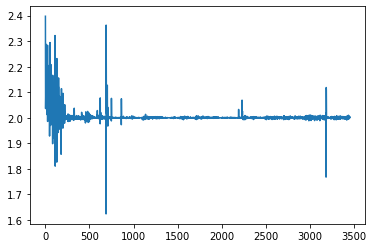

In [ ]:
compression = 10

loss = np.ndarray.flatten(loss_values)
loss = np.nanmean(np.pad(loss.astype(float), (0, compression - loss.size%compression), mode='constant', constant_values=np.NaN).reshape(-1, compression), axis=1)
plt.plot(loss)

# Rollouts

In [ ]:
simulator = tf.saved_model.load('./Zonal_Model_Sim')

In [ ]:
#@title ### Rollout Function

def rollout(simulator, features, num_steps):
  """Rolls out a trajectory by applying the model in sequence."""
  
  initial_positions = features['pos'][0:INPUT_SEQUENCE_LENGTH]
  initial_velocities = features['vel'][0:INPUT_SEQUENCE_LENGTH]
  ground_truth_positions = features['pos'][INPUT_SEQUENCE_LENGTH:]
  ground_truth_velocities = features['vel'][INPUT_SEQUENCE_LENGTH:]
  global_context = None
  
  def step_fn(step, current_positions, current_velocities, pos_predictions, vel_predictions):
    if global_context is None:
      global_context_step = None
    else:
      global_context_step = global_context[
          step + INPUT_SEQUENCE_LENGTH - 1][tf.newaxis]

    next_position, next_velocity = simulator(
        current_positions,
        current_velocities,
        n_particles_per_example=tf.constant([N]),
        particle_types=None,
        global_context=global_context_step)

    # Update kinematic particles from prescribed trajectory.
    kinematic_mask = get_kinematic_mask(tf.zeros(N))
    next_position_ground_truth = ground_truth_positions[step,:,:]
    next_velocity_ground_truth = ground_truth_velocities[step,:,:]
    next_position = tf.where(tf.expand_dims(kinematic_mask,-1), next_position_ground_truth,
                             next_position)
    next_velocity = tf.where(tf.expand_dims(kinematic_mask,-1), next_velocity_ground_truth,
                             next_velocity)
    updated_pos_predictions = pos_predictions.write(step, next_position)
    updated_vel_predictions = vel_predictions.write(step, next_velocity)

    # Shift `current_positions`, removing the oldest position in the sequence
    # and appending the next position at the end.
    next_positions = tf.concat([current_positions[1:,:,:],
                                next_position[tf.newaxis,:,:]], axis=0)
    next_velocities = tf.concat([current_velocities[1:,:,:],
                                next_velocity[tf.newaxis,:,:]], axis=0)
    return (step + 1, next_positions, next_velocities, updated_pos_predictions, updated_vel_predictions)
  
  pos_predictions = tf.TensorArray(size=num_steps, dtype=tf.float32)
  vel_predictions = tf.TensorArray(size=num_steps, dtype=tf.float32)

  _, _, _, pos_predictions, vel_predictions = tf.while_loop(
      cond=lambda step, state, vel, pos_prediction, vel_prediction: tf.less(step, num_steps),
      body=step_fn,
      loop_vars=(0, initial_positions, initial_velocities, pos_predictions, vel_predictions),
      parallel_iterations=1)

  output_dict = {
      'initial_positions': initial_positions,
      'initial_velocities': initial_velocities,
      'pos_predicted_rollout': pos_predictions.stack(),
      'vel_predicted_rollout': vel_predictions.stack(),
      'ground_truth_position_rollout': ground_truth_positions,
      'ground_truth_velocity_rollout': ground_truth_velocities
  }

  if global_context is not None:
    output_dict['global_context'] = global_context
  return output_dict

In [ ]:
#@title ### Rollouts

num_steps = metadata['sequence_length'] - INPUT_SEQUENCE_LENGTH

ds = tf.data.TFRecordDataset(['train_datasets/microstates-' + str(i) + '.tfrecords' for i in range(1)])

# map the record to features
ds = ds.map(_parse_record)

# map the features to tensors
ds = ds.map(_parse_tensor)

#print(ds.element_spec)

def make_dataset(x):
    # make a dataset from the time series tensor
    pos = tf.data.Dataset.from_tensors((x['pos']))
    vel = tf.data.Dataset.from_tensors((x['vel']))

    data = tf.data.Dataset.zip((pos, vel))
    #data = data.flat_map(lambda pos_ds,vel_ds: tf.data.Dataset.zip((pos_ds,vel_ds)))

    return data

# flatten the windowed dataset
#ds = ds.map(make_dataset)

for databatch in ds:
    output = rollout(simulator,databatch,num_steps)
    break

output['metadata'] = metadata
filename = '/zonal_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(output, file)

TypeError: ignored

In [ ]:
#@title ### Plots of Predicted Pos/Vel vs Ground Truth

from scipy import stats

fig, axs = plt.subplots(2,2, figsize=(8, 6), facecolor='w', edgecolor='k')  
labels = ["x values", "y values", "u values", "v values"]
axs = axs.ravel()
for pred_i in range(4):
    pred_list = tf.concat([output['pos_predicted_rollout'], output['vel_predicted_rollout']], axis=-1)
    true_list = tf.concat([output['ground_truth_position_rollout'], output['ground_truth_velocity_rollout']], axis=-1)

    pred_vals = np.array([pp[:,pred_i] for pp in pred_list]).flatten()
    true_vals = np.array([tt[:,pred_i] for tt in true_list]).flatten()

    bin_means, bin_edges, binnumber = stats.binned_statistic(true_vals, pred_vals,bins=100)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    bin_stds, bin_edges, binnumber = stats.binned_statistic(true_vals, pred_vals,statistic='std',bins=100)


    axs[pred_i].plot(bin_centers,bin_means,c='C0')

    axs[pred_i].fill_between(bin_centers,bin_means-bin_stds,bin_means+bin_stds,color='C0',alpha=0.5)

    xx = np.linspace(0,200,10)
    vv = np.linspace(-1,1,10)
    if pred_i<=1:
        axs[pred_i].plot(xx,xx,c='k',ls='--')
    else:
        axs[pred_i].plot(vv,vv,c='k',ls='--')
    axs[pred_i].set_ylabel('GNN prediction of parameter')
    axs[pred_i].set_xlabel('True parameter')
    axs[pred_i].set_title(labels[pred_i])

fig.tight_layout()

In [ ]:
#@title ### Order Parameter Plot

pred_av_velocity = np.mean(output['vel_predicted_rollout'],axis=1)
true_av_velocity = np.mean(output['ground_truth_velocity_rollout'],axis=1)
pred_std = np.std(output['vel_predicted_rollout'],axis=1)
true_std = np.std(output['ground_truth_velocity_rollout'],axis=1)

pred_order_parameter = np.linalg.norm(pred_av_velocity,axis=1)/vs
true_order_parameter = np.linalg.norm(true_av_velocity,axis=1)/vs

line = np.linspace(0,max(pred_order_parameter),10)
#plt.scatter(true_order_parameter, pred_order_parameter)
#plt.plot(line, line)

order = np.argsort(true_order_parameter)
true_order_parameter = true_order_parameter[order]
pred_order_parameter = pred_order_parameter[order]

bin_means, bin_edges, binnumber = stats.binned_statistic(true_order_parameter, pred_order_parameter,bins=100)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

bin_stds, bin_edges, binnumber = stats.binned_statistic(true_order_parameter, pred_order_parameter,statistic='std',bins=100)

plt.plot(bin_centers,bin_means,c='C0')
plt.xlabel("Ground Truth Order Parameter")
plt.ylabel("Predicted Order Parameter")
plt.fill_between(bin_centers,bin_means-bin_stds,bin_means+bin_stds,color='C0',alpha=0.5)


In [ ]:
#@title ### Render Rollouts

TYPE_TO_COLOR = {
    3: "black",  # Boundary particles.
    0: "green",  # Rigid solids.
    7: "magenta",  # Goop.
    6: "gold",  # Sand.
    5: "blue",  # Water.
}

step_stride = 3
block_on_show = True

with open(filename, "rb") as file:
  rollout_data = pickle.load(file)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

plot_info = []
Q={}
for ax_i, (label, (rollout_field_1, rollout_field_2)) in enumerate(
    [("Ground truth", ("ground_truth_position_rollout", "ground_truth_velocity_rollout")),
      ("Prediction", ("pos_predicted_rollout", "vel_predicted_rollout"))]):
  # Append the initial positions to get the full trajectory.
  pos_trajectory = np.concatenate([
      rollout_data["initial_positions"],
      rollout_data[rollout_field_1]], axis=0)
  vel_trajectory = np.concatenate([
      rollout_data["initial_velocities"],
      rollout_data[rollout_field_2]], axis=0)
  ax = axes[ax_i]
  ax.set_title(label)
  bounds = rollout_data["metadata"]["bounds"]
  ax.set_xlim(bounds[0][0], bounds[0][1])
  ax.set_ylim(bounds[1][0], bounds[1][1])
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_aspect(1.)
  points = {
      particle_type: ax.plot([], [], "o", ms=2, color=color)[0]
      for particle_type, color in TYPE_TO_COLOR.items()}
  X, Y, U, V = pos_trajectory[0,:,0], pos_trajectory[0,:,1], vel_trajectory[0,:,0], vel_trajectory[0,:,1]
  Q[f'{ax_i}'] = ax.quiver(X, Y, U, V, pivot='mid', color='b', units='inches')
  plot_info.append((ax, pos_trajectory, vel_trajectory, points))


num_steps = pos_trajectory.shape[0]


def update_quiver(num):
  for i, (ax, pos_trajectory, vel_trajectory, _) in enumerate(plot_info):
    U, V = vel_trajectory[num,:,0], vel_trajectory[num,:,1]
    offsets = pos_trajectory[num]

    Q[f'{i}'].set_offsets(offsets)
    Q[f'{i}'].set_UVC(U,V)
  return axes

anim = animation.FuncAnimation(fig, update_quiver,
                               interval=50, frames=np.arange(0, num_steps, step_stride),blit=False)
#plt.show(block=block_on_show)
rc('animation', html='jshtml')
anim
